# Perform submodular optimization to identify portfolio

## Import modules

In [381]:
import openml
import numpy as np
import json
import pandas as pd
import importlib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from utils import functions_best_setups
from utils.functions_best_setups import sub_opt, perf_imp

importlib.reload(functions_best_setups)


# set api key
openml.config.apikey = open('.key', 'r').readline().strip('\n')

## Get HGB evaluation matrix

In [2]:
# get HGB evals
evals_hgb = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[12736],
                                            output_format='dataframe')

evals_hgb.shape

(35708, 14)

In [200]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_hgb.setup_id.value_counts()).index[(evals_hgb.setup_id.value_counts() >= 68)]
evals_subset_hgb = evals_hgb[evals_hgb.setup_id.isin(ids)]

# transform to wide format
evals_wide_hgb = evals_subset_hgb.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')


In [201]:
evals_wide_hgb = evals_wide_hgb.drop([3573, 146825, 167124], axis = 1)
evals_wide_hgb


task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153768,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153789,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153791,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153802,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8168895,0.840000,0.500021,0.500546,0.500000,0.500000,0.644844,0.500000,0.500000,0.500000,0.505050,...,0.520221,0.500000,0.499851,0.500000,0.500000,0.500006,0.514574,0.500218,0.500272,0.813266
8168910,0.999597,0.999704,0.980430,0.998846,0.983405,0.990940,0.998489,0.954767,0.971019,0.707143,...,0.939711,0.989274,1.000000,0.994930,0.998962,0.974505,0.521389,0.980906,0.994357,0.928592
8168921,0.999661,0.999729,0.967361,0.998572,0.983552,0.990841,0.998274,0.947665,0.955634,0.695659,...,0.942308,0.989258,0.999990,0.995286,0.998738,0.981950,0.517092,0.978584,0.994514,0.922842


## Get SVC evaluation matrix

### Get evaluations

In [5]:
# get SVC evals
evals_svc = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[16374, 16347, 16345, 16366], 
                                            output_format='dataframe')

evals_svc = evals_svc[evals_svc.upload_time>'2019-11-16 22:50:39']

In [6]:
# get evals of mixed tasks and other tasks with unmatched setup ids
mixed_tasks = [23, 29, 31, 219, 2079, 3021, 3022, 7592, 9971, 9977, 14954, 14965, 125920, 167125, 167141, 3, 45, 49, 3560, 14952, 146195, 146821, 167125, 167140, 3573]
evals_mixed_svc = evals_svc[evals_svc.task_id.isin(mixed_tasks)]
evals_mixed_svc.shape
len(evals_mixed_svc.setup_id.unique())

3307

In [7]:
# get evals of pure tasks
#ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 19)]
evals_pure_svc = evals_svc[~evals_svc.task_id.isin(mixed_tasks)]
evals_pure_svc.shape
len(evals_pure_svc.setup_id.unique())

539

### Get setups

In [8]:
# get setups of mixed tasks
setup_info_names = list(evals_mixed_svc.columns)
param_names = ['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape',
               'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state',
               'shrinking', 'tol', 'verbose']

setups_mixed = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_mixed_svc.iterrows():
    setup_model = openml.setups.initialize_model(i[1].setup_id)
    params = setup_model.steps[2][1].get_params().values()
    setups_mixed.loc[len(setups_mixed)] = list(i[1])+list(params)

In [9]:
# get setups of pure tasks
setup_info_names = ['setup_id']
param_names = list(openml.setups.initialize_model(8231383).steps[2][1].get_params().keys())

setups_pure = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_pure_svc.setup_id.unique():
    setup_model = openml.setups.initialize_model(i)
    params = setup_model.steps[2][1].get_params().values()
    
    setups_pure.loc[len(setups_pure)] = [i]+list(params)


### Match and reassign setups to correct setup_ids

In [10]:
# match setup_ids
param_keys = ['C', 'coef0', 'degree', 'gamma', 'kernel', 'max_iter']
id_match = pd.DataFrame(columns= ['setup_id_mixed', 'setup_id'])

for i in range(len(setups_mixed)):
    print(i, end='\r')
    for j in range(len(setups_pure)):
        if all(setups_mixed.loc[i][param_keys] == setups_pure.loc[j][param_keys]): 
            id_match.loc[len(id_match)] = (setups_mixed.loc[i]['setup_id'], setups_pure.loc[j]['setup_id'])

In [11]:
evals_mixed_svc

,run_id,task_id,setup_id,flow_id,flow_name,data_id,data_name,function,upload_time,uploader,uploader_name,value,values,array_data
86629,10418942,146821,8255517,16347,sklearn.pipeline.Pipeline(simpleimputer=sklear...,40975,car,area_under_roc_curve,2019-12-03 22:23:43,8323,heinrichpeterz@gmail.com,0.999632,None,"[0.999654,0.999436,1,1]"
86630,10421085,167140,8255517,16347,sklearn.pipeline.Pipeline(simpleimputer=sklear...,40670,dna,area_under_roc_curve,2019-12-04 00:10:29,8323,heinrichpeterz@gmail.com,0.993973,None,"[0.994611,0.993424,0.993932]"
86631,10424181,3,8255530,16347,sklearn.pipeline.Pipeline(simpleimputer=sklear...,3,kr-vs-kp,area_under_roc_curve,2019-12-05 09:46:47,8323,heinrichpeterz@gmail.com,0.920713,None,"[0.920713,0.920713]"
86632,10429822,45,8255530,16347,sklearn.pipeline.Pipeline(simpleimputer=sklear...,46,splice,area_under_roc_curve,2019-12-09 05:37:16,8323,heinrichpeterz@gmail.com,0.991682,None,"[0.991885,0.989852,0.992438]"
86633,10425254,49,8255530,16347,sklearn.pipeline.Pipeline(simpleimputer=sklear...,50,tic-tac-toe,area_under_roc_curve,2019-12-05 10:23:35,8323,heinrichpeterz@gmail.com,0.841170,None,"[0.84117,0.84117]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96497,10437742,14965,8260883,16374,sklearn.pipeline.Pipeline(simpleimputer=sklear...,1461,bank-marketing,area_under_roc_curve,2020-02-18 19:11:42,8323,heinrichpeterz@gmail.com,0.678073,None,"[0.678073,0.678073]"
96498,10437743,14965,8260884,16374,sklearn.pipeline.Pipeline(simpleimputer=sklear...,1461,bank-marketing,area_under_roc_curve,2020-02-18 20:05:07,8323,heinrichpeterz@gmail.com,0.654759,None,"[0.654759,0.654759]"
96499,10437744,14965,8260885,16374,sklearn.pipeline.Pipeline(simpleimputer=sklear...,1461,bank-marketing,area_under_roc_curve,2020-02-18 20:16:30,8323,heinrichpeterz@gmail.com,0.671605,None,"[0.671605,0.671605]"
96500,10437745,14965,8260886,16374,sklearn.pipeline.Pipeline(simpleimputer=sklear...,1461,bank-marketing,area_under_roc_curve,2020-02-18 20:23:42,8323,heinrichpeterz@gmail.com,0.640067,None,"[0.640067,0.640067]"


In [12]:
id_match

,setup_id_mixed,setup_id
0,8255517,8231898
1,8255517,8255749
2,8255517,8231898
3,8255517,8255749
4,8255530,8231625
...,...,...
8389,8260884,8255930
8390,8260885,8232050
8391,8260885,8255760
8392,8260886,8255786


In [13]:
# reassign setup_ids
evals_mixed_final = pd.DataFrame(columns = evals_mixed_svc.columns.values)

for i in id_match.iterrows():
    try:
        x = evals_mixed_svc[evals_mixed_svc.setup_id == i[1][0]]
        x.iat[0,2] = i[1][1]
        evals_mixed_final.loc[len(evals_mixed_final)] = list(x.values[0])
    except Exception as e:
        print(e, end ='')
    

In [14]:
evals_mixed_final

,run_id,task_id,setup_id,flow_id,flow_name,data_id,data_name,function,upload_time,uploader,uploader_name,value,values,array_data
0,10418942,146821,8231898,16347,sklearn.pipeline.Pipeline(simpleimputer=sklear...,40975,car,area_under_roc_curve,2019-12-03 22:23:43,8323,heinrichpeterz@gmail.com,0.999632,None,"[0.999654,0.999436,1,1]"
1,10418942,146821,8255749,16347,sklearn.pipeline.Pipeline(simpleimputer=sklear...,40975,car,area_under_roc_curve,2019-12-03 22:23:43,8323,heinrichpeterz@gmail.com,0.999632,None,"[0.999654,0.999436,1,1]"
2,10418942,146821,8231898,16347,sklearn.pipeline.Pipeline(simpleimputer=sklear...,40975,car,area_under_roc_curve,2019-12-03 22:23:43,8323,heinrichpeterz@gmail.com,0.999632,None,"[0.999654,0.999436,1,1]"
3,10418942,146821,8255749,16347,sklearn.pipeline.Pipeline(simpleimputer=sklear...,40975,car,area_under_roc_curve,2019-12-03 22:23:43,8323,heinrichpeterz@gmail.com,0.999632,None,"[0.999654,0.999436,1,1]"
4,10424181,3,8231625,16347,sklearn.pipeline.Pipeline(simpleimputer=sklear...,3,kr-vs-kp,area_under_roc_curve,2019-12-05 09:46:47,8323,heinrichpeterz@gmail.com,0.920713,None,"[0.920713,0.920713]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8389,10437743,14965,8255930,16374,sklearn.pipeline.Pipeline(simpleimputer=sklear...,1461,bank-marketing,area_under_roc_curve,2020-02-18 20:05:07,8323,heinrichpeterz@gmail.com,0.654759,None,"[0.654759,0.654759]"
8390,10437744,14965,8232050,16374,sklearn.pipeline.Pipeline(simpleimputer=sklear...,1461,bank-marketing,area_under_roc_curve,2020-02-18 20:16:30,8323,heinrichpeterz@gmail.com,0.671605,None,"[0.671605,0.671605]"
8391,10437744,14965,8255760,16374,sklearn.pipeline.Pipeline(simpleimputer=sklear...,1461,bank-marketing,area_under_roc_curve,2020-02-18 20:16:30,8323,heinrichpeterz@gmail.com,0.671605,None,"[0.671605,0.671605]"
8392,10437745,14965,8255786,16374,sklearn.pipeline.Pipeline(simpleimputer=sklear...,1461,bank-marketing,area_under_roc_curve,2020-02-18 20:23:42,8323,heinrichpeterz@gmail.com,0.640067,None,"[0.640067,0.640067]"


### Recreate evaluation matrix with matched setups

In [15]:
# merge pure and mixed setups
evals_svc = evals_pure_svc.append(evals_mixed_final)

In [195]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 30)]
evals_subset_svc = evals_svc[evals_svc.setup_id.isin(ids)]

# transform to wide format
evals_wide_svc = evals_subset_svc.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

In [196]:
evals_wide_svc

task_id,3,6,11,12,14,15,16,18,22,23,...,125922,146800,146817,146819,146820,146822,146824,167119,167120,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8255509,0.979148,0.989495,0.981979,0.999275,0.980622,0.994573,0.998110,NaN,NaN,0.693388,...,0.999745,0.999696,0.902443,0.952077,0.991964,0.974699,0.999370,NaN,NaN,0.880809
8255510,0.986995,0.993091,0.980991,0.999125,0.982386,0.994972,0.997976,0.960343,NaN,0.682877,...,0.999954,0.999619,0.902759,0.949613,0.985389,0.980924,0.998829,NaN,NaN,0.883022
8255511,0.999868,NaN,0.999104,0.950226,NaN,NaN,NaN,NaN,NaN,NaN,...,0.999987,NaN,0.919777,0.925189,0.993476,0.992367,0.524062,NaN,NaN,NaN
8255513,0.990997,0.995431,0.987158,0.999425,0.981152,0.994582,0.999211,0.958083,NaN,0.721782,...,0.999908,0.999986,0.915162,0.949503,0.992449,0.980378,0.999548,NaN,NaN,0.887175
8255514,0.989217,0.993589,0.981123,0.999137,0.981871,0.994981,0.997771,0.961297,NaN,0.682734,...,0.999966,0.999634,0.903286,0.952561,0.985148,0.981547,0.998824,NaN,NaN,0.882811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8255934,0.920700,NaN,0.964759,0.997585,0.963252,NaN,0.993484,NaN,NaN,0.687027,...,0.985277,0.960719,0.881620,0.950713,0.765970,0.941302,0.997845,NaN,NaN,0.748707
8255938,0.990832,0.994135,0.980422,0.999124,0.981244,0.995053,0.997768,0.966006,0.986707,0.684563,...,0.999972,0.999585,0.904997,0.952781,0.978551,0.983655,0.998746,0.785172,NaN,0.581293
8255939,0.991260,0.997457,0.953448,0.493664,0.489772,0.977631,0.497107,0.963570,0.538000,0.577637,...,0.999185,0.367981,0.875179,0.430228,0.960503,0.988708,0.495350,0.898225,NaN,0.412310


## Merge HGB and SVC data 

In [271]:
evals_wide_merged = pd.concat([evals_wide_hgb, evals_wide_svc])
evals_wide_merged

task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153768,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153789,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153791,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153802,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8255934,0.920700,NaN,0.964759,0.997585,0.963252,NaN,0.993484,NaN,NaN,0.687027,...,0.950713,0.765970,NaN,0.941302,0.997845,NaN,NaN,NaN,NaN,0.748707
8255938,0.990832,0.994135,0.980422,0.999124,0.981244,0.995053,0.997768,0.966006,0.986707,0.684563,...,0.952781,0.978551,NaN,0.983655,0.998746,0.785172,NaN,NaN,NaN,0.581293
8255939,0.991260,0.997457,0.953448,0.493664,0.489772,0.977631,0.497107,0.963570,0.538000,0.577637,...,0.430228,0.960503,NaN,0.988708,0.495350,0.898225,NaN,NaN,NaN,0.412310


In [236]:
x = evals_wide_merged.isna().sum()
x.loc[x>0]

task_id
6          29
14         14
15         30
16         14
18         47
22         69
23         14
29         29
31         29
32         48
37         43
43         10
45        270
49        270
219       100
2079       29
3021      270
3022       14
3481       16
3549       14
3560      270
3903       43
3904       74
3917       12
7592      180
9910       29
9952       60
9960       36
9971       43
9976       39
9977       42
9985      206
10093      23
10101       1
14952     270
14954      29
14965     115
14969      40
14970      25
125920     14
146195    270
146800     14
146821    270
146822      2
167119    210
167120    257
167125    270
167140    270
167141     15
dtype: int64

## Submodular optimization AUC (min-max scaled, mean)

In [475]:
def eval_transformer(evals, replace_missing=True, order_id=False):
    # normalize evaluation metrics within tasks
    
    evals.loc[len(evals)] = 0
    
    evals_norm = pd.DataFrame(MinMaxScaler().fit_transform(X = evals), 
                               index= evals.index,
                               columns = evals.columns)
    
    evals_norm =evals_norm.drop(len(evals_norm)-1, axis=0)
    
    if replace_missing==True:
        evals_norm = evals_norm.fillna(0)
        
        
    if order_id==True:
            order_setups = np.argsort(evals_norm.index)
            order_tasks = np.argsort(evals_norm.columns)                     
    else:                 
        order_setups = np.argsort(evals_norm.mean(axis = 1))
        order_tasks = np.argsort(evals_norm.mean(axis = 0))
    evals_norm_ordered = evals_norm.iloc[order_setups, order_tasks]
    
    return evals_norm_ordered

In [476]:
evals_wide_merged_norm_ordered = eval_transformer(evals_wide_merged, replace_missing=False)
evals_wide_merged_norm_clean_ordered = eval_transformer(evals_wide_merged)

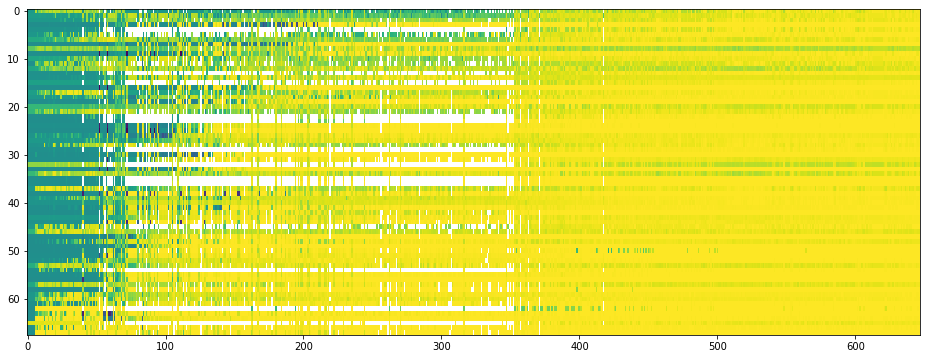

In [477]:
plt.figure(figsize = (16, 6))
plt.imshow(evals_wide_merged_norm_ordered.T, aspect = 'auto')

In [478]:
order_setups = np.argsort(evals_wide_merged_norm_clean.mean(axis = 1))
order_tasks = np.argsort(evals_wide_merged_norm_clean.mean(axis = 0))

evals_wide_merged_norm_clean_ordered = evals_wide_merged_norm_clean.iloc[order_setups, order_tasks]

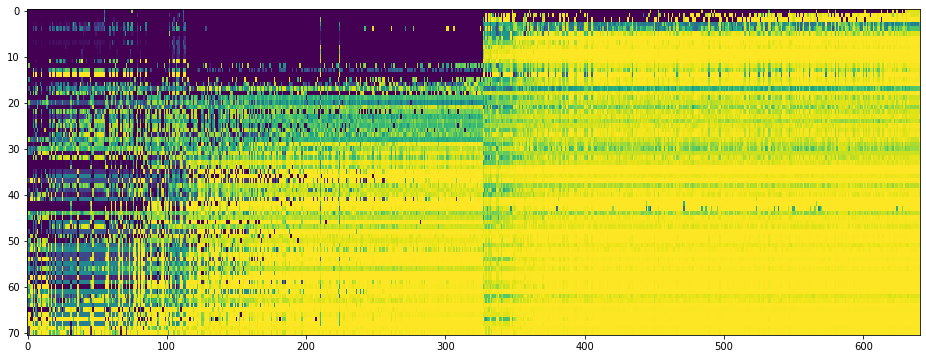

In [479]:
plt.figure(figsize = (16, 6))
plt.imshow(evals_wide_merged_norm_clean_ordered.T, aspect = 'auto')

## Plot performance improvement for each additional classifier

In [480]:
setup_id, portfolio_performance = perf_imp(evals_wide_merged_norm_clean, evals_wide_merged_norm_clean, criterion='mean', verbose = True)

sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.svm.classes.SVC
sklearn.svm.classes.SVC
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.svm.classes.SVC
sklearn.svm.classes.SVC
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier
sklearn.svm.classes.SVC
sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradien

''

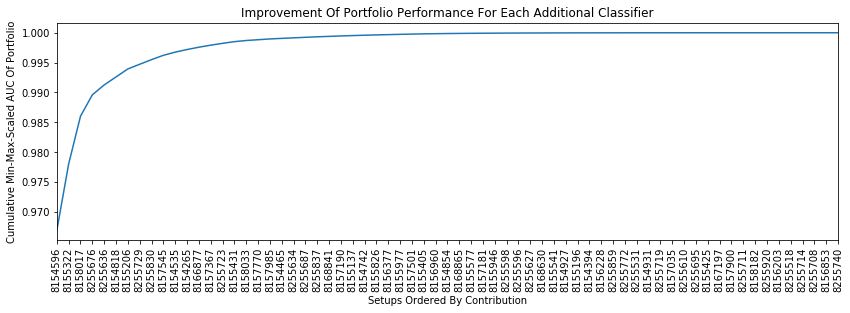

In [481]:
ax = pd.Series(portfolio_performance).plot(figsize = (14,4), xticks=range(len(setup_id)))
ax.set_xticklabels(labels=setup_id, rotation = 90)
ax.set_ylabel('Cumulative Min-Max-Scaled AUC Of Portfolio')
ax.set_xlabel('Setups Ordered By Contribution')
ax.set_title('Improvement Of Portfolio Performance For Each Additional Classifier')
;

''

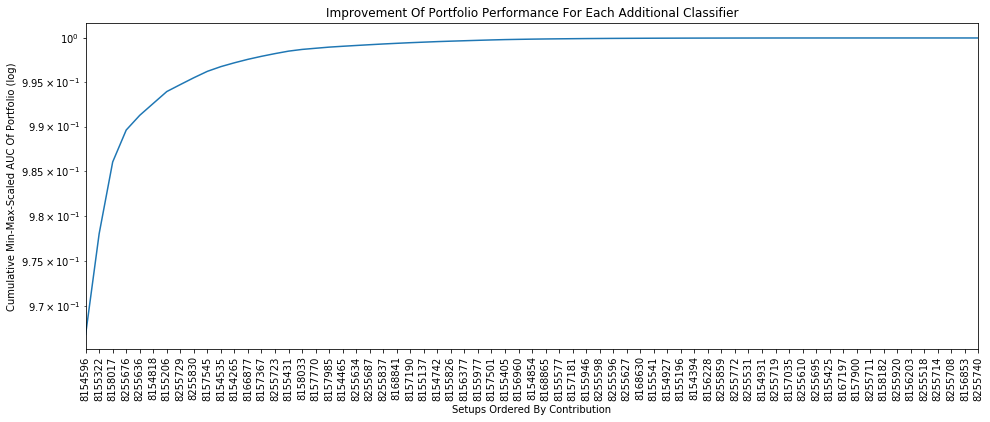

In [482]:
ax = pd.Series(portfolio_performance).plot(figsize = (16,6), xticks=range(len(setup_id)))
ax.set_xticklabels(labels=setup_id, rotation = 90)
ax.set_yscale('log')
ax.set_ylabel('Cumulative Min-Max-Scaled AUC Of Portfolio (log)')
ax.set_xlabel('Setups Ordered By Contribution')
ax.set_title('Improvement Of Portfolio Performance For Each Additional Classifier')
;

In [483]:
pp_neg = [1-i for i in portfolio_performance]

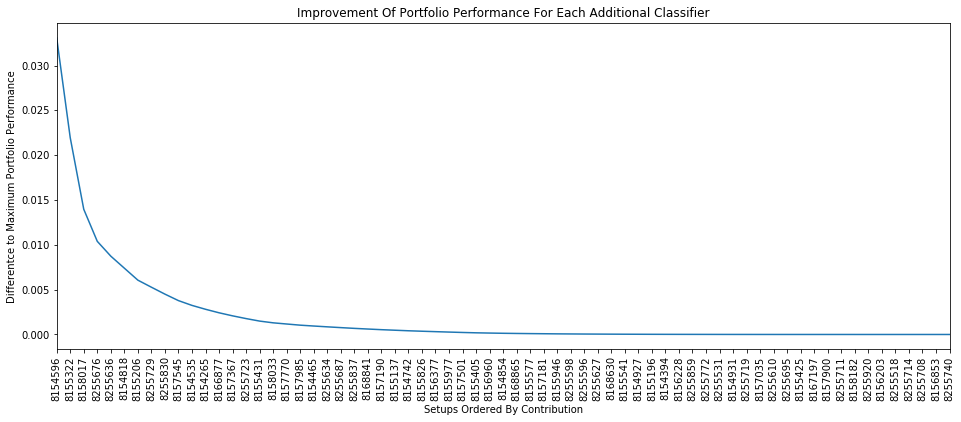

In [484]:
ax = pd.Series(pp_neg).plot(figsize = (16,6), xticks=range(len(setup_id)))
ax.set_xticklabels(labels=setup_id, rotation = 90)
ax.set_ylabel('Differentce to Maximum Portfolio Performance')
ax.set_xlabel('Setups Ordered By Contribution')
ax.set_title('Improvement Of Portfolio Performance For Each Additional Classifier');


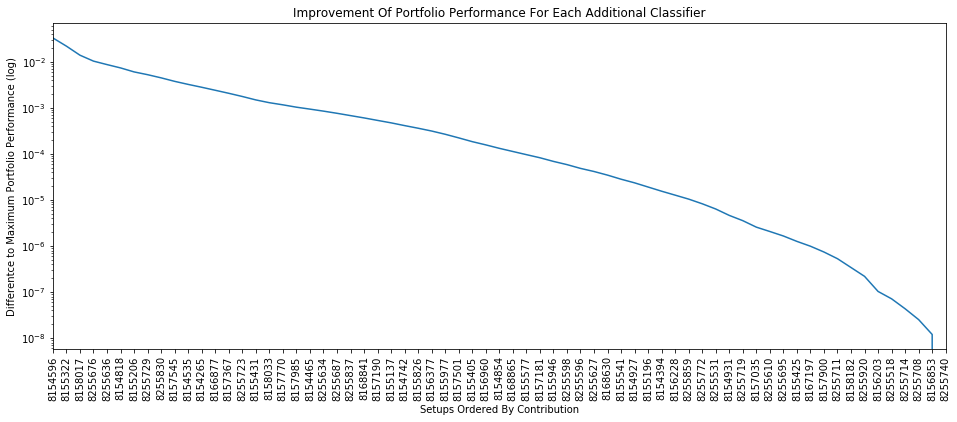

In [485]:
ax = pd.Series(pp_neg).plot(figsize = (16,6), xticks=range(len(setup_id)))
ax.set_xticklabels(labels=setup_id, rotation = 90)
ax.set_yscale('log')
ax.set_ylabel('Differentce to Maximum Portfolio Performance (log)')
ax.set_xlabel('Setups Ordered By Contribution')
ax.set_title('Improvement Of Portfolio Performance For Each Additional Classifier');


## Compare performance

In [486]:
merged_clean=eval_transformer(evals_wide_merged, order_id=1)
setup_id, portfolio_performance_merged_mean = perf_imp(merged_clean, evals_wide_merged, 'mean')

In [487]:
svc_clean=eval_transformer(evals_wide_svc, order_id=1)
setup_id, portfolio_performance_svc_mean = perf_imp(svc_clean, evals_wide_svc, 'mean')

In [488]:
hgb_clean=eval_transformer(evals_wide_hgb, order_id=1)
setup_id, portfolio_performance_hgb_mean = perf_imp(hgb_clean, evals_wide_hgb, 'mean')

In [489]:
merged_clean_max=eval_transformer(evals_wide_merged, order_id=1)
setup_id, portfolio_performance_merged_max = perf_imp(merged_clean_max, evals_wide_merged, 'max')

''

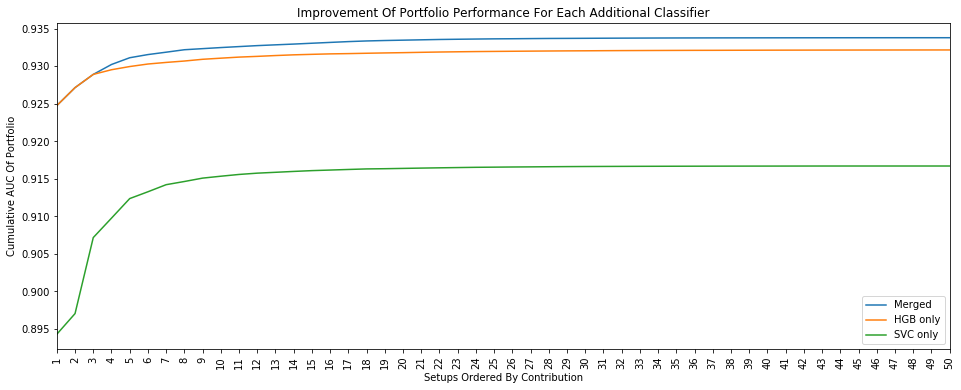

In [511]:
ax1 = pd.Series(portfolio_performance_merged_mean[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(portfolio_performance_hgb_mean[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(portfolio_performance_svc_mean[0:50]).plot(figsize = (16,6), xticks=range(50))
#ax1 = pd.Series(portfolio_performance_merged_max[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'Merged max'])
ax1.set_yscale('linear')
ax1.set_ylabel('Cumulative AUC Of Portfolio')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Improvement Of Portfolio Performance For Each Additional Classifier')
;

In [491]:
merged_clean_max=eval_transformer(evals_wide_merged, order_id=1)
setup_id, portfolio_performance_merged_max = perf_imp(merged_clean_max, evals_wide_merged, 'max')

In [492]:
svc_clean=eval_transformer(evals_wide_svc, order_id=1)
setup_id, portfolio_performance_svc_max = perf_imp(svc_clean, evals_wide_svc, 'max')

In [493]:
hgb_clean=eval_transformer(evals_wide_hgb, order_id=1)
setup_id, portfolio_performance_hgb_max = perf_imp(hgb_clean, evals_wide_hgb, 'max')

''

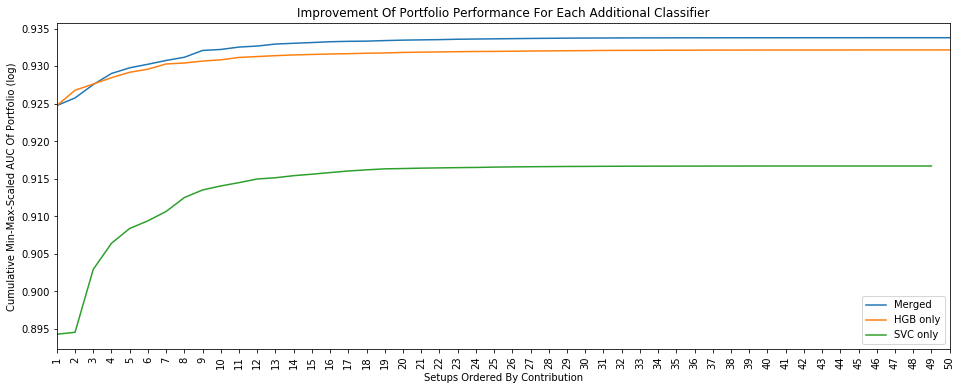

In [494]:
ax1 = pd.Series(portfolio_performance_merged_max[0:50]).plot(figsize = (16,6), xticks=range(50))
ax2 = pd.Series(portfolio_performance_hgb_max[0:50]).plot(figsize = (16,6), xticks=range(50))
ax3 = pd.Series(portfolio_performance_svc_max[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only'])
#ax1.set_yscale('log')
ax1.set_ylabel('Cumulative Min-Max-Scaled AUC Of Portfolio (log)')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Improvement Of Portfolio Performance For Each Additional Classifier')
;

## Get model condigurations

In [495]:
# get ensemble of X setups
evals_merged_final = eval_transformer(evals_wide_merged, replace_missing=1, order_id=1)
setup_list_auc_merged_mean = sub_opt(evals_merged_final, 31, 'mean')
print(setup_list_auc_merged_mean)

[8156960, 8156475, 8155196, 8255596, 8255723, 8255729, 8155137, 8154265, 8168924, 8255830, 8157367, 8157985, 8154465, 8157770, 8155431, 8154535, 8168841, 8255837, 8154742, 8255687, 8157190, 8155977, 8155826, 8156377, 8157545, 8255634, 8155405, 8158033, 8155322, 8157501, 8168865, 8255636]


In [496]:
counter = 1
for i in setup_list_auc_merged_mean:

    print(str(openml.setups.initialize_model(i)[-1])+',')
    print()
    counter += 1

HistGradientBoostingClassifier(l2_regularization=10.0, learning_rate=0.1,
                               loss='auto', max_bins=256, max_depth=16,
                               max_iter=100, max_leaf_nodes=128,
                               min_samples_leaf=8, n_iter_no_change=None,
                               random_state=10427, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0),

HistGradientBoostingClassifier(l2_regularization=1e-10, learning_rate=0.1,
                               loss='auto', max_bins=64, max_depth=2,
                               max_iter=100, max_leaf_nodes=4,
                               min_samples_leaf=3, n_iter_no_change=None,
                               random_state=25689, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0),

HistGradientBoostingClassifier(l2_regularization=1e-05, learning_rate=0.1,
                               loss='auto', max_bins=256, max_depth=

HistGradientBoostingClassifier(l2_regularization=0.001, learning_rate=0.01,
                               loss='auto', max_bins=64, max_depth=9,
                               max_iter=450, max_leaf_nodes=32,
                               min_samples_leaf=12, n_iter_no_change=None,
                               random_state=26193, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0),

HistGradientBoostingClassifier(l2_regularization=1.0, learning_rate=0.1,
                               loss='auto', max_bins=256, max_depth=10,
                               max_iter=450, max_leaf_nodes=64,
                               min_samples_leaf=12, n_iter_no_change=None,
                               random_state=59156, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0),

HistGradientBoostingClassifier(l2_regularization=10.0, learning_rate=0.1,
                               loss='auto', max_bins=8, max_depth=2

In [497]:
evals_hgb_final = eval_transformer(evals_wide_hgb, replace_missing=1, order_id=1)
setup_list_auc_hgb_mean = sub_opt(evals_hgb_final, 31, 'mean')
print(setup_list_auc_hgb_mean)

[8156960, 8156475, 8155196, 8154107, 8157870, 8154265, 8155137, 8155322, 8168841, 8157985, 8154465, 8157367, 8154535, 8157903, 8154742, 8155234, 8157665, 8157190, 8157770, 8156685, 8155977, 8155247, 8155826, 8157910, 8155405, 8156377, 8167197, 8158033, 8155577, 8157501, 8154835, 8168865]


In [498]:
counter = 1
for i in setup_list_auc_hgb_mean:

    print(openml.setups.initialize_model(i)[-1], ',')
    print()
    counter += 1

HistGradientBoostingClassifier(l2_regularization=10.0, learning_rate=0.1,
                               loss='auto', max_bins=256, max_depth=16,
                               max_iter=100, max_leaf_nodes=128,
                               min_samples_leaf=8, n_iter_no_change=None,
                               random_state=10427, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0) ,

HistGradientBoostingClassifier(l2_regularization=1e-10, learning_rate=0.1,
                               loss='auto', max_bins=64, max_depth=2,
                               max_iter=100, max_leaf_nodes=4,
                               min_samples_leaf=3, n_iter_no_change=None,
                               random_state=25689, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0) ,

HistGradientBoostingClassifier(l2_regularization=1e-05, learning_rate=0.1,
                               loss='auto', max_bins=256, max_dept

HistGradientBoostingClassifier(l2_regularization=0.001, learning_rate=0.1,
                               loss='auto', max_bins=256, max_depth=19,
                               max_iter=300, max_leaf_nodes=128,
                               min_samples_leaf=5, n_iter_no_change=None,
                               random_state=2250, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0) ,

HistGradientBoostingClassifier(l2_regularization=10.0, learning_rate=0.1,
                               loss='auto', max_bins=256, max_depth=15,
                               max_iter=200, max_leaf_nodes=64,
                               min_samples_leaf=1, n_iter_no_change=None,
                               random_state=18644, scoring=None, tol=1e-07,
                               validation_fraction=0.2, verbose=0) ,

HistGradientBoostingClassifier(l2_regularization=0.001, learning_rate=0.01,
                               loss='auto', max_bins=64, max_de

In [499]:
evals_wide_merged_norm_clean

task_id,3,6,11,12,14,15,16,18,22,23,...,146821,146822,146824,146825,167119,167120,167124,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999774,0.999863,0.953120,0.999346,0.998213,0.994214,0.999048,0.984829,0.970141,0.836813,...,0.999996,0.999413,0.999301,0.950439,0.986593,0.721848,0.954038,0.995772,0.998978,0.984770
8153768,0.999774,0.999863,0.953120,0.999346,0.998213,0.994214,0.999048,0.984829,0.970141,0.836813,...,0.999996,0.999413,0.999301,0.950439,0.986593,0.721848,0.954038,0.995772,0.998978,0.984770
8153789,0.999774,0.999863,0.953120,0.999346,0.998213,0.994214,0.999048,0.984829,0.970141,0.836813,...,0.999996,0.999413,0.999301,0.950439,0.986593,0.721848,0.954038,0.995772,0.998978,0.984770
8153791,0.999774,0.999863,0.953120,0.999346,0.998213,0.994214,0.999048,0.984829,0.970141,0.836813,...,0.999996,0.999413,0.999301,0.950439,0.986593,0.721848,0.954038,0.995772,0.998978,0.984770
8153802,0.999774,0.999863,0.953120,0.999346,0.998213,0.994214,0.999048,0.984829,0.970141,0.836813,...,0.999996,0.999413,0.999301,0.950439,0.986593,0.721848,0.954038,0.995772,0.998978,0.984770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8255934,0.912031,0.000000,0.945052,0.998090,0.975779,0.000000,0.993943,0.000000,0.000000,0.752761,...,0.000000,0.937056,0.998207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.661604
8255938,0.989909,0.988702,0.969474,0.999666,0.995610,0.999897,0.998326,0.995308,0.993636,0.742896,...,0.000000,0.985715,0.999125,0.000000,0.590806,0.000000,0.000000,0.000000,0.000000,0.351789
8255939,0.990383,0.995340,0.927417,0.481733,0.453938,0.971732,0.486000,0.992435,0.494970,0.314809,...,0.000000,0.991521,0.486100,0.000000,0.824988,0.000000,0.000000,0.000000,0.000000,0.039071


In [500]:
hgb_clean

task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8168895,0.840068,0.500126,0.502437,0.500392,0.507497,0.649558,0.500625,0.518594,0.512249,0.674497,...,0.542719,0.503266,0.499851,0.501963,0.500431,0.508801,0.970836,0.508095,0.502774,0.873011
8168910,0.999677,0.999915,0.984134,0.999630,0.998150,0.998184,0.999737,0.990274,0.994807,0.944393,...,0.980351,0.995735,1.000000,0.998837,0.999823,0.991646,0.983694,0.996352,0.999330,0.996808
8168921,0.999741,0.999940,0.971015,0.999356,0.998299,0.998084,0.999521,0.982907,0.979046,0.929055,...,0.983059,0.995719,0.999990,0.999195,0.999598,0.999223,0.975587,0.993994,0.999488,0.990636


In [501]:
svc_clean

task_id,3,6,11,12,14,15,16,18,22,23,...,125922,146800,146817,146819,146820,146822,146824,167119,167120,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8255934,0.920787,0.000000,0.964759,0.998135,0.978189,0.000000,0.994077,0.000000,0.000000,0.929828,...,0.985280,0.960720,0.948241,0.996219,0.770170,0.947806,0.998240,0.000000,0.0,0.814750
8255938,0.990926,0.994372,0.980422,0.999674,0.996461,0.999936,0.998363,0.995898,0.994230,0.926493,...,0.999975,0.999586,0.973384,0.998386,0.983916,0.990451,0.999141,0.809077,0.0,0.632568
8255939,0.991354,0.997695,0.953448,0.493936,0.497367,0.982429,0.497403,0.993386,0.542102,0.781780,...,0.999188,0.367981,0.941313,0.450821,0.965770,0.995539,0.495546,0.925571,0.0,0.448680


In [502]:
print(portfolio_performance_hgb_mean)

[0.9247461947016957, 0.9271372080011961, 0.9288985386199903, 0.9295193995551548, 0.9299446730403306, 0.9302814453157915, 0.9304937424509826, 0.9306793962434554, 0.930910796439543, 0.931058770256802, 0.9312023276744649, 0.9312998016137745, 0.9314093428215872, 0.93150475550514, 0.9315704693101506, 0.9316317195905615, 0.9316675787618162, 0.9317146008966699, 0.9317572870362142, 0.9317941217701078, 0.9318390410726543, 0.9318789953279343, 0.9319097718139694, 0.9319389227998116, 0.9319599815662363, 0.9319797458086408, 0.9319981239956215, 0.9320152825121994, 0.9320308823150961, 0.9320424411739543, 0.9320560594690238, 0.9320688662724427, 0.9320774609250351, 0.9320856581119155, 0.9320938822525136, 0.9321016026420087, 0.9321053585735557, 0.9321120866795288, 0.9321182386403131, 0.9321245005445928, 0.9321290677649996, 0.9321332606598915, 0.9321370760283534, 0.9321403073915159, 0.932143389107497, 0.9321461406524895, 0.9321487672864764, 0.932151202532503, 0.932152892734172, 0.9321542604967652, 0.9321

In [503]:
print(portfolio_performance_merged_mean)

[0.9247461947016957, 0.9271372080011961, 0.9288985386199903, 0.9302188626774108, 0.9311172401663181, 0.9315387861731713, 0.9318563586856508, 0.9321829387126562, 0.9323282549186188, 0.9324721745554391, 0.9326024055360632, 0.9327313354947431, 0.9328360675180533, 0.9329372283109675, 0.9330493002143742, 0.9331588414221869, 0.9332662686564145, 0.9333528868296905, 0.9334115703383685, 0.9334580772600658, 0.9335039307931564, 0.9335488500957028, 0.933579944525822, 0.933606756092685, 0.9336328878796691, 0.9336474693590545, 0.9336668754901369, 0.9336840340067148, 0.9336937372957933, 0.9337052961546515, 0.9337169214732435, 0.9337276690747619, 0.9337360379124362, 0.9337447977619331, 0.933751390899188, 0.9337568314540595, 0.9337610243489517, 0.9337642557121143, 0.9337671090922723, 0.9337701908082534, 0.9337728174422404, 0.9337752526882669, 0.9337776214019561, 0.9337794583580373, 0.9337807717558744, 0.9337816768701178, 0.933782413331369, 0.933783191504029, 0.9337837062099114, 0.9337840661908404, 0.93

In [504]:
evals_hgb_final.mean(axis=1).max()

0.9908805492054673

In [505]:
evals_merged_final.mean(axis=1).max()

0.9890294814108667

In [506]:
evals_hgb_final.T.describe()

setup_id,371,372,373,374,375,376,377,378,379,380,...,8168752,8168772,8168841,8168865,8168880,8168895,8168910,8168921,8168924,8168931
count,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.000000,68.000000,68.000000,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.545123,0.545123,0.545123,...,0.986771,0.982733,0.980130,0.984392,0.695490,0.648944,0.983673,0.985414,0.977997,0.983730
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081856,0.081856,0.081856,...,0.020221,0.030566,0.028260,0.023074,0.206076,0.172371,0.024599,0.025808,0.032320,0.030800
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.500000,...,0.907365,0.871811,0.889000,0.900779,0.498095,0.499851,0.893000,0.896374,0.839957,0.850016
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500620,0.500620,0.500620,...,0.985045,0.981776,0.978105,0.980943,0.502198,0.501917,0.980784,0.983728,0.972417,0.984272
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508334,0.508334,0.508334,...,0.994311,0.996454,0.993333,0.994773,0.576159,0.545871,0.995271,0.996540,0.989100,0.996231
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541596,0.541596,0.541596,...,0.999749,0.999349,0.998937,0.999620,0.919965,0.821212,0.999618,0.999540,0.997491,0.999579
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.943339,0.943339,0.943339,...,1.000000,1.000000,1.000000,1.000000,0.999998,1.000000,1.000000,1.000000,0.999989,1.000000


In [507]:
evals_merged_final.T.describe()

setup_id,641,642,643,644,645,646,647,648,649,650,...,8255920,8255922,8255924,8255926,8255930,8255934,8255938,8255939,8255951,8256151
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.0,68.0,68.0,68.0,...,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,0.543946,0.543946,0.543946,0.543946,0.543946,0.543946,0.0,0.0,0.0,0.0,...,0.671264,0.685519,0.595248,0.349666,0.787594,0.460413,0.765161,0.635322,0.669696,0.763704
std,0.080555,0.080555,0.080555,0.080555,0.080555,0.080555,0.0,0.0,0.0,0.0,...,0.391341,0.385420,0.427120,0.465771,0.372535,0.469284,0.368538,0.349869,0.386050,0.381367
min,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500293,0.500293,0.500293,0.500293,0.500293,0.500293,0.0,0.0,0.0,0.0,...,0.466443,0.490586,0.000000,0.000000,0.865364,0.000000,0.793727,0.493831,0.533276,0.820895
50%,0.507685,0.507685,0.507685,0.507685,0.507685,0.507685,0.0,0.0,0.0,0.0,...,0.877127,0.900253,0.864660,0.000000,0.979148,0.314629,0.964787,0.773691,0.862765,0.957861
75%,0.541486,0.541486,0.541486,0.541486,0.541486,0.541486,0.0,0.0,0.0,0.0,...,0.974911,0.974860,0.976953,0.978807,0.997901,0.960505,0.994479,0.923043,0.980941,0.997134
max,0.942252,0.942252,0.942252,0.942252,0.942252,0.942252,0.0,0.0,0.0,0.0,...,1.000000,1.000000,0.999981,0.999995,1.000000,0.999776,0.999975,1.000000,0.999985,1.000000


In [508]:
evals_hgb_final.loc[8153766]

task_id
3         0.999796
6         0.999931
11        0.973597
12        0.999595
14        0.998354
            ...   
167119    0.993414
167120    0.985116
167125    0.997915
167140    0.999491
167141    0.991166
Name: 8153766, Length: 68, dtype: float64

In [509]:
evals_merged_final.loc[8153766]

task_id
3         0.999796
6         0.999931
11        0.969933
12        0.999361
14        0.998354
            ...   
167119    0.993414
167120    0.983981
167125    0.997915
167140    0.999491
167141    0.991166
Name: 8153766, Length: 68, dtype: float64